# Language Prediction and Analysis
Dastan Abdulla  
Ling 1340: Data Science for Linguists  
04/08/2024  

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Imports
import pandas as pd
import numpy as np
# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
bio_df = pd.read_pickle('../data/bio_df.pkl')
bio_df.head(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,phonetic_transcription,ethnologue_language_code,language_name,macroarea,coordinate
0,1,afrikaans,south africa,27.0,female,9.0,usa,0.50,academic,afrikaans1.wav,afrikaans1.txt,afr,Afrikaans,Africa,"(-30.559482, 22.937506)"
1,2,afrikaans,south africa,40.0,male,5.0,usa,10.00,academic,afrikaans2.wav,afrikaans2.txt,afr,Afrikaans,Africa,"(-30.559482, 22.937506)"
2,3,agni,côte d'ivoire,25.0,male,15.0,usa,1.20,academic,agni1.wav,agny1.txt,any,Anyin,Africa,"(7.539989, -5.54708)"
3,4,albanian,serbia,19.0,male,6.0,usa,3.00,naturalistic,albanian1.wav,albanian1.txt,als,Tosk Albanian,Eurasia,"(44.016521, 21.005859)"
4,5,albanian,albania,33.0,male,15.0,usa,0.04,naturalistic,albanian2.wav,albanian2.txt,aln,Gheg Albanian,Eurasia,"(41.153332, 20.168331)"


In [4]:
features_df = pd.read_pickle('../data/features_df.pkl')
features_df.head(5)

,speakerid,transcription,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,1,pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪ...,114,126,38,1,74,1,166,87,...,4,24,31,138,89,0,165,12,11,45
1,2,pʰliːz̥ kʰɔl stɛ̆lʌ ɔsk hɜ tŭ bɹiŋ ðiz θiŋz̥ ...,109,125,37,6,69,1,160,85,...,6,24,31,131,84,0,162,15,9,43
2,3,pliz kɑl stelə æs hɚ tu bɹɪ̃ŋ viz fɪŋ wɪf hɜɹ̆...,111,119,45,1,59,1,158,78,...,0,26,31,134,81,0,164,4,16,51
3,4,p̬liz kʰɔl stɛla æs xɜɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋks wɪ...,119,129,39,5,79,0,173,95,...,0,33,39,145,87,0,173,13,8,47
4,5,pliz kɔl stɛlə æsk hɛɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋs wɪð ...,122,136,37,1,63,0,171,97,...,4,35,33,138,87,0,159,15,11,41


In [5]:
saa_tran_df = pd.concat([bio_df, features_df], axis=1)

In [6]:
saa_tran_df.head(5)

,speakerid,native_language,country,age,gender,onset_age,english_residence,length_of_residence,learning_style,speech_sample,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,1,afrikaans,south africa,27.0,female,9.0,usa,0.50,academic,afrikaans1.wav,...,4,24,31,138,89,0,165,12,11,45
1,2,afrikaans,south africa,40.0,male,5.0,usa,10.00,academic,afrikaans2.wav,...,6,24,31,131,84,0,162,15,9,43
2,3,agni,côte d'ivoire,25.0,male,15.0,usa,1.20,academic,agni1.wav,...,0,26,31,134,81,0,164,4,16,51
3,4,albanian,serbia,19.0,male,6.0,usa,3.00,naturalistic,albanian1.wav,...,0,33,39,145,87,0,173,13,8,47
4,5,albanian,albania,33.0,male,15.0,usa,0.04,naturalistic,albanian2.wav,...,4,35,33,138,87,0,159,15,11,41


# Preliminary setup
Before we begin building the classification models, we need to make sure that there ample instances of each tag or label for our model to learn from. i.e if there are only 2 instances for one native language, then our model will have an extra tag to differentiate from which would hurt the performance

In [7]:
feature_full_names = [
    'anterior',
    'consonantal',
    'labial',
    'sagittal',
    'back',
    'constricted_glottis',
    'continuant',
    'coronal',
    'delayed_release',
    'high',
    'lateral',
    'low',
    'long',
    'nasal',
    'round',
    'sonorant',
    'syllabic',
    'velaric',
    'voice',
    'distributed',
    'strident',
    'tense'
]


# Testing Correlation 
Before we build a prediction model, we need to check for correlation between the features and native_languages as it will give us an idea of how our model will perform.

In [8]:
import pandas as pd
from scipy.stats import kruskal
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

for feature in feature_full_names:
    stat, p = kruskal(*[group[f'{feature}'].values for name, group in saa_tran_df.groupby("language_name")])
    if p >= 0.05:
        print('Feature: ', feature)
        print('Kruskal-Wallis Test stat=%s, p=%s' % (stat, p))
        print("ANOVA: ")
        model = ols(f'{feature} ~ C(language_name)', data=saa_tran_df).fit()
        anova_results = anova_lm(model)
        print(anova_results)
    else:
        print('Feature: ', feature , '\t\tSignificant: p = ', p)


Feature:  anterior 		Significant: p =  2.4176664843839433e-25
Feature:  consonantal 		Significant: p =  3.8669675325099395e-31
Feature:  labial 		Significant: p =  1.0861877801837978e-11
Feature:  sagittal 		Significant: p =  8.166656923727007e-15
Feature:  back 		Significant: p =  9.926245999272957e-06
Feature:  constricted_glottis 		Significant: p =  1.8479455945109385e-06
Feature:  continuant 		Significant: p =  4.591131169294219e-12
Feature:  coronal 		Significant: p =  7.204539063077842e-21
Feature:  delayed_release
Kruskal-Wallis Test stat=101.4203076891935, p=0.9999999999991324
ANOVA: 
                      df     sum_sq   mean_sq         F  PR(>F)
C(language_name)   218.0   0.785983  0.003605  0.311575     1.0
Residual          1050.0  12.150187  0.011572       NaN     NaN
Feature:  high 		Significant: p =  1.4518456054154734e-11
Feature:  lateral 		Significant: p =  2.7645796859362385e-10
Feature:  low 		Significant: p =  0.0003152737687833769
Feature:  long 		Significant: p =

## Conclusion
The results clearly indicate that the language has a statistically significant effect on speech features, with very low p-values (< 0.0001) suggesting strong evidence against the null hypothesis, except for when it comes to the delayed_release. 


# Predicting Native Language

In [9]:
model_data = saa_tran_df[['language_name'] + feature_full_names]
model_data.head()

,language_name,anterior,consonantal,labial,sagittal,back,constricted_glottis,continuant,coronal,delayed_release,...,long,nasal,round,sonorant,syllabic,velaric,voice,distributed,strident,tense
0,Afrikaans,114,126,38,1,74,1,166,87,0,...,4,24,31,138,89,0,165,12,11,45
1,Afrikaans,109,125,37,6,69,1,160,85,0,...,6,24,31,131,84,0,162,15,9,43
2,Anyin,111,119,45,1,59,1,158,78,0,...,0,26,31,134,81,0,164,4,16,51
3,Tosk Albanian,119,129,39,5,79,0,173,95,0,...,0,33,39,145,87,0,173,13,8,47
4,Gheg Albanian,122,136,37,1,63,0,171,97,0,...,4,35,33,138,87,0,159,15,11,41


In [10]:
value_counts = model_data['language_name'].value_counts()
value_counts

language_name
English                       186
Spanish                        74
French                         44
Dutch                          42
Portuguese                     39
                             ... 
Baga Sitemu                     1
Guadeloupean Creole French      1
Zulu                            1
Central Bai                     1
Masbatenyo                      1
Name: count, Length: 219, dtype: int64

In [11]:
value_counts = model_data['language_name'].value_counts()
to_remove = value_counts[value_counts < 2].index
print(len(to_remove))
to_remove

95


Index(['Mankanya', 'Balanta-Ganja', 'Luba-Lulua', 'Mandinka',
       'Jamaican Creole English', 'Nyanja', 'Konkani (individual language)',
       'Lushai', 'Susu', 'Tetun Dili', 'Fataluku', 'Tajik', 'Moba', 'Turkmen',
       'Shilluk', 'Nandi', 'Klao', 'Nuer', 'Plateau Malagasy', 'Omani Arabic',
       'Southern Kurdish', 'Luxembourgish', 'Rundi', 'Yakut', 'Faroese',
       'Pedi', 'Sa'a', 'Kabyle', 'Adamawa Fulfulde', 'Papiamento', 'Kalanga',
       'Xaasongaxango', 'Arabic', 'Lingala', 'Khoekhoe', 'Gedeo',
       'Northern Pashto', 'Central Kanuri', 'Gan Chinese', 'Kinyarwanda',
       'Vengo', 'Ngemba', 'Jola-Fonyi', 'Carolinian', 'Chamorro', 'Anyin',
       'Zoroastrian Dari', 'Tatar', 'Ebira', 'Bini', 'Tofanma',
       'Fang (Cameroon)', 'Western Frisian', 'Sicilian', 'Kannada', 'Sarua',
       'Gallurese Sardinian', 'Huamalíes-Dos de Mayo Huánuco Quechua',
       'South Bolivian Quechua', 'Kirghiz', 'Western Panjabi', 'Lamaholot',
       'Pohnpeian', 'Mortlockese', 'Mossi', 'Mori

- Based on the value counts distribution, there is no benefit in keeping the labels that occur only once in our data, so it'd make sense to remove them.

In [12]:
model_data = model_data[~model_data['language_name'].isin(to_remove)]
value_counts = model_data['language_name'].value_counts()
value_counts

language_name
English                 186
Spanish                  74
French                   44
Dutch                    42
Portuguese               39
                       ... 
San Salvador Kongo        2
Mende (Sierra Leone)      2
North Azerbaijani         2
Belarusian                2
Malayalam                 2
Name: count, Length: 124, dtype: int64

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'combined_df' is your DataFrame with all features and the language label
X = model_data[feature_full_names]
y = model_data['language_name']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.2553191489361702


In [14]:
X.shape

(1174, 22)

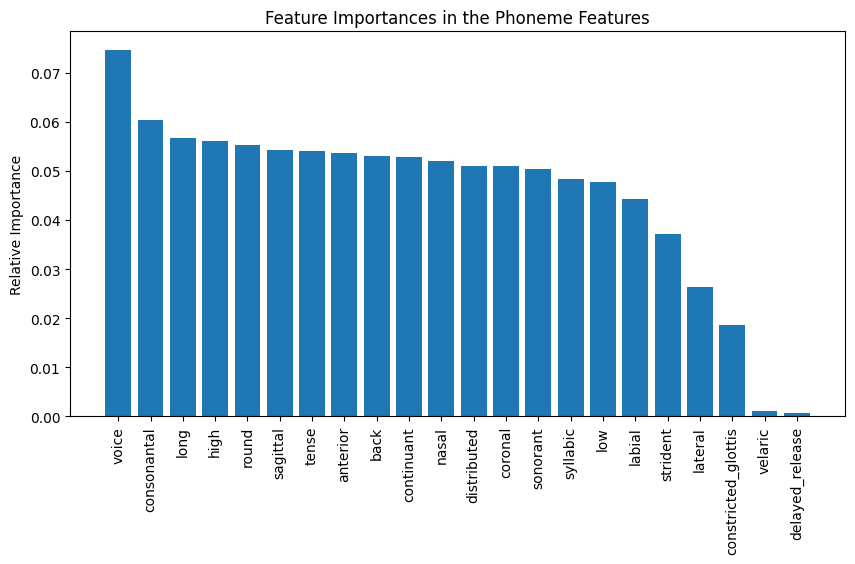

In [15]:
importances = model.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Visualize the feature importances
plt.figure(figsize=(10, 5))  
plt.title('Feature Importances in the Phoneme Features')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [feature_full_names[i] for i in indices], rotation=90)
plt.ylabel('Relative Importance')
plt.show()

In [16]:
len(model_data['language_name'].unique())

124

The model did not perform very well when it comes to detecting the specific language that was spoken. But this is inherently a difficult task. Let's see if the true labels are at least in the top predictions.

In [17]:
def test_top_occurence(x_test, y_test, k):
    y_probs = model.predict_proba(x_test)
    top_preds_indices = np.argsort(y_probs, axis=1)[:, -k:]
    top_class_labels = np.array(model.classes_)[top_preds_indices]
    y_test_array = y_test.to_numpy()
    # Check if the true labels are within the top k predictions
    matches_top = np.array([y_test_array[i] in top_class_labels[i] for i in range(len(y_test_array))])
    return matches_top.mean()

top_k = list(range(1, 100, 1))
accuracies_phon = [test_top_occurence(X_test, y_test, k) for k in top_k]

## What if we used the Transcriptions?

In [18]:
saa_tran_df['transcription'][:5]

0    pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪ...
1    pʰliːz̥ kʰɔl stɛ̆lʌ ɔsk hɜ tŭ bɹiŋ ðiz θiŋz̥ ...
2    pliz kɑl stelə æs hɚ tu bɹɪ̃ŋ viz fɪŋ wɪf hɜɹ̆...
3    p̬liz kʰɔl stɛla æs xɜɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋks wɪ...
4    pliz kɔl stɛlə æsk hɛɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋs wɪð ...
Name: transcription, dtype: object

In [19]:
model_data = saa_tran_df[['transcription', 'language_name']]
model_data.head()

,transcription,language_name
0,pʰlis kɔl stɛːlʌ ɑsk˺ ɜ tə bɹɪ̃ŋ ðiz θɪ̃ŋz̥ wɪ...,Afrikaans
1,pʰliːz̥ kʰɔl stɛ̆lʌ ɔsk hɜ tŭ bɹiŋ ðiz θiŋz̥ ...,Afrikaans
2,pliz kɑl stelə æs hɚ tu bɹɪ̃ŋ viz fɪŋ wɪf hɜɹ̆...,Anyin
3,p̬liz kʰɔl stɛla æs xɜɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋks wɪ...,Tosk Albanian
4,pliz kɔl stɛlə æsk hɛɹ tu bɹɪ̃ŋ ðɪs θɪ̃ŋs wɪð ...,Gheg Albanian


In [20]:
value_counts = model_data['language_name'].value_counts()
to_remove = value_counts[value_counts < 2].index
model_data = model_data[~model_data['language_name'].isin(to_remove)]
value_counts = model_data['language_name'].value_counts()
value_counts

language_name
English                 186
Spanish                  74
French                   44
Dutch                    42
Portuguese               39
                       ... 
San Salvador Kongo        2
Mende (Sierra Leone)      2
North Azerbaijani         2
Belarusian                2
Malayalam                 2
Name: count, Length: 124, dtype: int64

In [21]:
def phoneme_tokenizer(transcript):
    no_whitespace_transcript = transcript.replace(' ', '')
    return [*no_whitespace_transcript]

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Extracting the phoneme transcriptions and language labels
transcriptions = model_data['transcription']
languages = model_data['language_name']

# Unigrams
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1500 , tokenizer=phoneme_tokenizer, lowercase=False, token_pattern=None)
X = vectorizer.fit_transform(transcriptions)
feature_names = vectorizer.get_feature_names_out()
y = model_data['language_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.19574468085106383


That is worse than the random forests model used for the Panphon phoneme columns, but we can make it better if we used trigrams.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Extracting the phoneme transcriptions and language labels
transcriptions = model_data['transcription']
languages = model_data['language_name']

vectorizer = TfidfVectorizer(max_df=0.5, max_features=1500 , tokenizer=phoneme_tokenizer, lowercase=False, token_pattern=None, ngram_range=(1, 3))
X = vectorizer.fit_transform(transcriptions)
feature_names = vectorizer.get_feature_names_out()
y = model_data['language_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.251063829787234


In [24]:
X.shape

(1174, 1500)

Over 6% improvement woah!

In [25]:
log_prob = model.feature_log_prob_

# Display the most informative features for each class
for i, class_prob in enumerate(log_prob[:10]):
    # Sort the probabilities along with feature names
    sorted_features = sorted(zip(class_prob, feature_names), reverse=True)
    print(f"Top features for class {i}: ", [tup[1] for tup in sorted_features[:10]])

Top features for class 0:  ['h ɜ', '̚', 'ɛ ̆', '̆ n', 'ɛ ɪ', 'z θ', 'i ŋ', 'ə ʊ', 'ə n', 'ŋ z ̥']
Top features for class 1:  ['ɛ ː', 'ɛ n', 'h ɛ', 'l ˠ', 'ˠ', 't ʊ', 'ː s', 'i ː s', '˺', 'ɔ l ˠ']
Top features for class 2:  ['r', 's t ̪', '̪ ɪ', 'ɪ s', 't ̪ ɪ', 'ɝ', 'h ɝ', '̪ ɪ ̃', 'ɪ s t', 'ɔ f']
Top features for class 3:  ['ə ɹ', 'h ə ɹ', 'ɝ', 'h ɝ', 'r', 'h ə', 'ə ɹ b', 'f ɔ ɹ', 'ɹ b', 'ŋ z ̥']
Top features for class 4:  ['s ̪', 'r', 'ʔ', 'e s', 'i k s', 'ɜ ɹ', 'z t', 'k i d', 'i d ̥', 'k i']
Top features for class 5:  ['̞', 'æ ̞', 'a ̃ n', 'a ̃', 'z ̥ s', 'ɪ ̆', 'ɔ v', 'z ̥ ɔ', 'k a', '̥ ɔ']
Top features for class 6:  ['r', 'x', 'x ɜ', 'ɛ s t', '̱', 'ɛ s', 's t ̪', 's ɔ', 'r b', 'x ɛ']
Top features for class 7:  ['r', 'h ɛ r', 'ɛ r', 'd ̥ e', 't u ̆', 'h ɜ', '̥ e', 'd ̥', 's ɪ ̃', 'u ̆']
Top features for class 8:  ['ʈ', 'r', 'h ɜ', '̪ i', '˺', 't ̪ ɪ', '̝', 'l a', 'ʰ i', 'd ̪ i']
Top features for class 9:  ['̪ ɪ', 'r', 'v i', 't ̪ ɪ', 'h ɝ', 'ɝ', 'v ɪ', 'ɛ r', 'n d', '˞']


In [26]:
accuracies_vec = [test_top_occurence(X_test, y_test, k) for k in top_k]

## What If We Used the Audio Features?

In [27]:
audio_df = pd.read_pickle('../data/audio_features.pkl')
audio_df.head()

,features,file
0,"[-320.2046203613281, 113.08561706542969, 13.68...",afrikaans1.wav
1,"[-293.78033447265625, 124.66605377197266, -6.4...",afrikaans2.wav
2,"[-338.8608703613281, 132.85476684570312, 6.337...",afrikaans3.wav
3,"[-285.78668212890625, 136.85784912109375, 8.95...",afrikaans4.wav
4,"[-371.3587646484375, 134.38897705078125, 3.720...",afrikaans5.wav


In [28]:
audio_df['country'] = audio_df['file'].str.replace('\d+\.wav', '', regex=True)
print('Unique Countries: ', len(audio_df['country'].unique()))
audio_df['country'].value_counts()

Unique Countries:  234


country
english        658
spanish        240
arabic         198
mandarin       156
korean          99
              ... 
nandi            1
nama             1
mortlockese      1
moore            1
zulu             1
Name: count, Length: 234, dtype: int64

In [29]:
# Similar to before, remove the single instances
value_counts = audio_df['country'].value_counts()
to_remove = value_counts[value_counts < 2].index
audio_df = audio_df[~audio_df['country'].isin(to_remove)]
value_counts = audio_df['country'].value_counts()
print('Unique Countries: ', len(audio_df['country'].unique()))
value_counts

Unique Countries:  141


country
english       658
spanish       240
arabic        198
mandarin      156
korean         99
             ... 
hmong           2
quechua         2
hiligaynon      2
satawalese      2
hadiyya         2
Name: count, Length: 141, dtype: int64

In [30]:
# Split the features and the labels
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report


X = np.array(audio_df['features'].tolist())
y = np.array(audio_df['country'].tolist())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, zero_division=True))

                          precision    recall  f1-score   support

                albanian       1.00      0.00      0.00         1
                 amharic       0.00      0.00      1.00         6
                  arabic       0.21      0.28      0.24        43
                armenian       1.00      0.00      0.00         2
                     asl       1.00      0.00      0.00         1
             azerbaijani       1.00      0.00      0.00         2
                    bari       1.00      0.00      0.00         1
                  basque       1.00      0.00      0.00         1
                 bengali       1.00      0.00      0.00         6
                 bosnian       1.00      0.00      0.00         1
               bulgarian       0.00      0.00      1.00         8
               cantonese       1.00      0.00      0.00         6
                croatian       0.00      0.00      1.00         2
                   czech       1.00      0.00      0.00         1
         

In [31]:
X.shape

(2923, 21)

In [32]:
def test_top_occurence_custom(x_test, y_test, k):
    y_probs = model.predict_proba(x_test)
    top_preds_indices = np.argsort(y_probs, axis=1)[:, -k:]
    top_class_labels = np.array(model.classes_)[top_preds_indices]
    y_test_array = y_test
    # Check if the true labels are within the top k predictions
    matches_top = np.array([y_test_array[i] in top_class_labels[i] for i in range(len(y_test_array))])
    return matches_top.mean()

In [33]:
accuracies_wav = [test_top_occurence_custom(X_test, y_test, k) for k in top_k]

# Phoneme vs Vectorized vs Audio Features

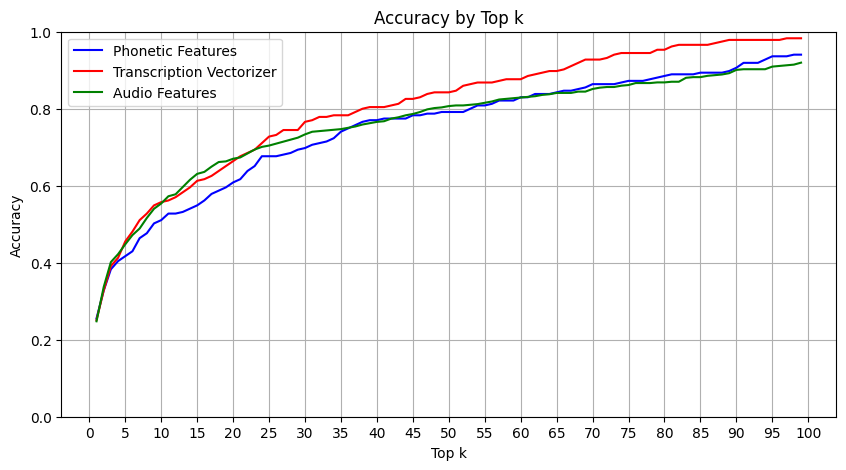

In [34]:
# Plotting the data
plt.figure(figsize=(10, 5))  
plt.plot(top_k, accuracies_phon, color = 'blue', label = 'Phonetic Features')  
plt.plot(top_k, accuracies_vec, color = 'red', label = 'Transcription Vectorizer')  
plt.plot(top_k, accuracies_wav, color = 'green', label = 'Audio Features')  
plt.title('Accuracy by Top k')  
plt.xlabel('Top k')  
plt.ylabel('Accuracy') 
plt.grid(True) 
plt.xticks(range(0, 105, 5))  # Ensure all model numbers are labeled
plt.ylim(0, 1.0)  # Optionally set the y-axis limits to zoom in on accuracies
plt.legend()
plt.show()

- Overall, The three models basically performed relatively the same, however, some of them are more space efficient than others.
- When we were looking at a single true labels, none of the models performed well, however, considering that our 'guessing' accuracy is around 1/124 (1/number of possible labels)=0.08% (or 1/141 for the audio features case since we are considering the entire dataset for that), our model(s) was able to do very well compared to that baseline.
- It improved even further when we considered top_k bins, in which we checked whether the true label was among the top most probable choices for the models predictions, our accuracy jumped to 60% around the top 15-10 mark, which, considering the number of classes we have to distinguish between is very good.